In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import networkx as nx

In [3]:
# Read from csv
sig_df = pd.read_csv('Dijet_bb_pt20_50_dw.csv')
bkg_df = pd.read_csv('Dijet_qq_pt20_50_dw.csv')

In [4]:
# Distinguish signal and background
sig_df['IsB'] = 1
bkg_df['IsB'] = 0

# Separate Jet 0 and Jet 1 data
sig_jet0 = sig_df[sig_df.columns[sig_df.columns.str.contains("Jet0|IsB")]]
bkg_jet0 = bkg_df[bkg_df.columns[bkg_df.columns.str.contains("Jet0|IsB")]]

sig_jet1 = sig_df[sig_df.columns[sig_df.columns.str.contains("Jet1|IsB")]]
bkg_jet1 = bkg_df[bkg_df.columns[bkg_df.columns.str.contains("Jet1|IsB")]]

# Combine signal and background and shuffle
train_df = pd.concat([sig_jet0, bkg_jet0]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([sig_jet1, bkg_jet1]).sample(frac=1, random_state=42).reset_index(drop=True)

In [5]:
# Make cuts on data
def train_make_cuts(train_df, test_df):
    
    train_cut_df_sig = train_df[(train_df['IsB'] == 1) & (train_df['Jet0_MC_Match'] == 1) & (train_df['Jet0_MC_Jet_EfB'] > 0.6)]
    train_cut_df_bkg = train_df[(train_df['IsB'] == 0) & (train_df['Jet0_MC_Match'] == 1) & (train_df['Jet0_MC_Jet_EfB'] < 0.6) & (train_df['Jet0_MC_Jet_EfD'] < 0.6)]

    test_cut_df_sig = test_df[(test_df['IsB'] == 1) & (test_df['Jet1_MC_Match'] == 1) & (test_df['Jet1_MC_Jet_EfB'] > 0.6)]
    test_cut_df_bkg = test_df[(test_df['IsB'] == 0) & (test_df['Jet1_MC_Match'] == 1) & (test_df['Jet1_MC_Jet_EfB'] < 0.6) & (test_df['Jet1_MC_Jet_EfD'] < 0.6)]
    
    train_cut_df = pd.concat([train_cut_df_sig, train_cut_df_bkg], ignore_index=True)
    test_cut_df = pd.concat([test_cut_df_sig, test_cut_df_bkg], ignore_index=True)
    return train_cut_df, test_cut_df

# Calculate Delta R
def deltaR(df, eta_col, phi_col):
    df['DeltaR'] = None 

    for i, row in df.iterrows():
        eta1 = df.loc[i, eta_col]
        eta2 = df.loc[(i+1), eta_col]
        phi1 = df.loc[i, phi_col]
        phi2 = df.loc[(i+1), phi_col]
        deltaR = np.sqrt((eta2 - eta1) ** 2 + (phi2 - phi1) ** 2)
        df.at[i, 'DeltaR'] = deltaR

# Duplicate data to lists matching the number of daughters/ nodes per jet/ row
def duplicate(df, cols, n_col):
    for col in cols:
        df[col] = df.apply(lambda row: [row[col]] * row[n_col] if isinstance(row[col], (float, int)) else row[col], axis=1)
    return df

# Convert string values into list of floats
def convert_to_lists(df, d_cols):
    for col in d_cols:
        df[col] = df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)
    return df

In [6]:
# Track/ daughter kinematic features
train_d_cols = [col for col in train_df.columns if "_Daughters" in col]
test_d_cols = [col for col in test_df.columns if "_Daughters" in col]

# Jet input features
train_jet_cols = ['Jet0_Eta', 'Jet0_PT']  #, 'Jet0_nmuons', 'Jet0_muon_ProbNNMu', 'Jet0_muon_IPchi2'] later add DeltaR
test_jet_cols = ['Jet1_Eta', 'Jet1_PT'] #, 'Jet1_nmuons', 'Jet1_muon_ProbNNMu', 'Jet1_muon_IPchi2'] later add DeltaR

# Features columns (daughter kinematics + jet inputs)
train_f_cols = train_d_cols + train_jet_cols
test_f_cols = test_d_cols + test_jet_cols

# Make cuts to data
train_df, test_df = train_make_cuts(train_df, test_df)

# Duplicate single features for each node
train_df = duplicate(train_df, train_jet_cols, 'Jet0_nDaughters')
test_df = duplicate(test_df, test_jet_cols, 'Jet1_nDaughters')

# Convert strings into float lists
train_df = convert_to_lists(train_df, train_d_cols)
test_df = convert_to_lists(test_df, test_d_cols)

# Shuffle data
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [67]:
list(train_df.columns)

['Jet0_ENDVERTEX_X',
 'Jet0_ENDVERTEX_Y',
 'Jet0_ENDVERTEX_Z',
 'Jet0_ENDVERTEX_XERR',
 'Jet0_ENDVERTEX_YERR',
 'Jet0_ENDVERTEX_ZERR',
 'Jet0_ENDVERTEX_CHI2',
 'Jet0_ENDVERTEX_NDOF',
 'Jet0_OWNPV_X',
 'Jet0_OWNPV_Y',
 'Jet0_OWNPV_Z',
 'Jet0_OWNPV_XERR',
 'Jet0_OWNPV_YERR',
 'Jet0_OWNPV_ZERR',
 'Jet0_OWNPV_CHI2',
 'Jet0_OWNPV_NDOF',
 'Jet0_IP_OWNPV',
 'Jet0_IPCHI2_OWNPV',
 'Jet0_FD_OWNPV',
 'Jet0_FDCHI2_OWNPV',
 'Jet0_DIRA_OWNPV',
 'Jet0_ORIVX_X',
 'Jet0_ORIVX_Y',
 'Jet0_ORIVX_Z',
 'Jet0_ORIVX_XERR',
 'Jet0_ORIVX_YERR',
 'Jet0_ORIVX_ZERR',
 'Jet0_ORIVX_CHI2',
 'Jet0_ORIVX_NDOF',
 'Jet0_FD_ORIVX',
 'Jet0_FDCHI2_ORIVX',
 'Jet0_DIRA_ORIVX',
 'Jet0_P',
 'Jet0_PT',
 'Jet0_PE',
 'Jet0_PX',
 'Jet0_PY',
 'Jet0_PZ',
 'Jet0_MM',
 'Jet0_MMERR',
 'Jet0_M',
 'Jet0_ID',
 'Jet0_Eta',
 'Jet0_Phi',
 'Jet0_MLoKi',
 'Jet0_MMLoKi',
 'Jet0_NTrk',
 'Jet0_N90',
 'Jet0_MTF',
 'Jet0_NSatCells',
 'Jet0_NHasPVInfo',
 'Jet0_JEC_Cor',
 'Jet0_JEC_PV',
 'Jet0_JEC_Error',
 'Jet0_w',
 'Jet0_CPF',
 'Jet0_JetWidth',
 'Je

In [7]:
# Cut out some data for quicker runs
train_df = train_df.head(100000) 
ttest_df = test_df.head(100000)

In [8]:
# Create node feature array: [jet][daughter][feature]
def node_features(df, features_cols):
    features_list = []
    
    for _, row in df.iterrows():

        max_nodes = max(len(row[col]) if isinstance(row[col], list) else 1 for col in features_cols)
        jet_nodes = [[] for _ in range(max_nodes)]
        
        for column in features_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(max_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    return np.array(features_list, dtype=object)

# Create graphs for each jet - orig
def create_data_objects(df, features_array):
    data_objects = []
    for idx, features in enumerate(features_array):

        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)
        num_classes = 2 # binary classification

        # Fully connected edges
        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        y = torch.tensor([df['IsB'].iloc[idx]], dtype=torch.float)
        
        data = Data(x=x, edge_index=edge_index, y=y, num_classes=num_classes, num_nodes=num_nodes)
        data_objects.append(data)

    return data_objects

# Extract node features
train_features = node_features(train_df, train_f_cols)
test_features = node_features(test_df, test_f_cols)

# Create graphs for each jet
train_data = create_data_objects(train_df, train_features)
test_data = create_data_objects(test_df, test_features)

# Load Data in batches
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

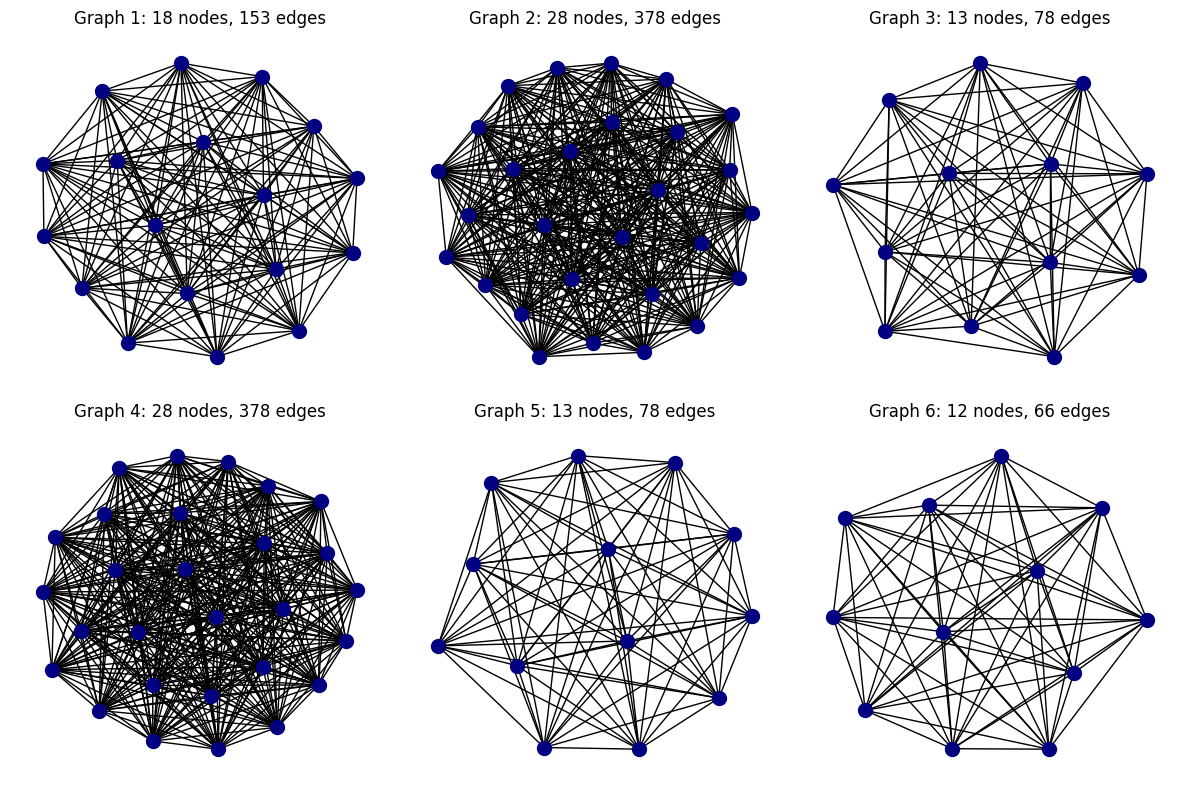

In [12]:
# Visualize some graphs
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, data in enumerate(train_loader.dataset[:6]):
    G = nx.Graph()
    G.add_edges_from(data.edge_index.t().tolist())

    nx.draw(G, ax=axes[i], node_color='navy', node_size=100)
    
    axes[i].set_title(f"Graph {i+1}: {data.num_nodes} nodes, {data.edge_index.size(1)} edges")

plt.tight_layout()
plt.show()

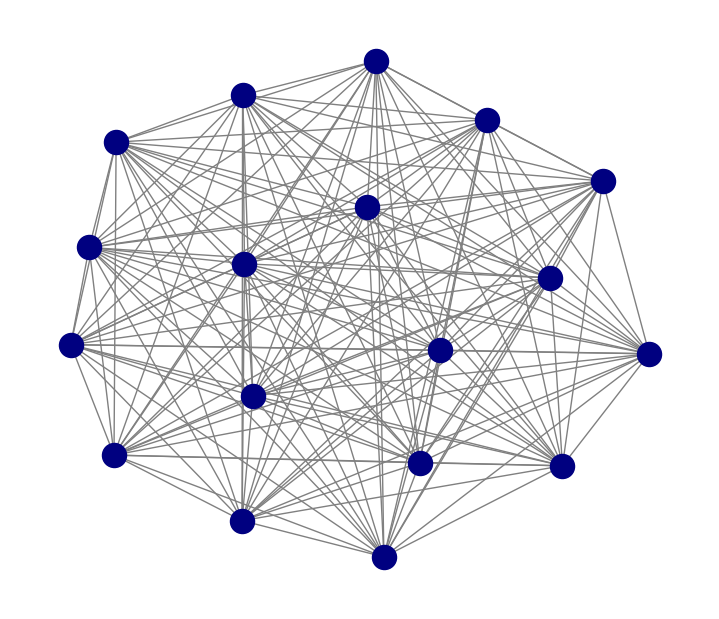

In [54]:
# Create the graph
G = nx.Graph()
G.add_edges_from(train_loader.dataset[0].edge_index.t().tolist())

# Get some basic info about the graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Use spring layout for better node distribution
pos = nx.spring_layout(G)

# Draw the graph
plt.figure(figsize=(7, 6))
nx.draw(G, pos, 
        node_color='navy', 
        node_size=300, 
        edge_color='grey',
        font_weight='bold')

# Show the plot
plt.show()

In [ ]:
for data in train_loader:
    print(f"x shape: {data.x[0]}") # [num_nodes, num_features]
    print(f"edge_index shape: {data.edge_index.shape}") # [2, num_edges] fully connected
    print(f"y: {data.y}") # labels
    print(f"batch shape: {data.batch.shape[0]}") #num nodes in this batch
    print("###########################################")

x shape: tensor([ 4.3429e+03,  5.2557e+02, -2.2000e+01, -3.0168e+01, -5.2471e+02,
         4.3110e+03,  2.8013e+00, -1.6282e+00,  0.0000e+00, -1.0000e+02,
        -1.0000e+10, -1.0000e+02, -1.0000e+03, -1.0000e+03, -1.0000e+03,
        -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03,
        -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03,
        -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03,  2.6763e+00,
         3.4524e+04])
edge_index shape: torch.Size([2, 9158])
y: tensor([1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
        0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 1., 1., 0., 1., 1., 1.])
batch shape: 1024
###########################################
x shape: tensor([ 4.3411e+03,  1.6801e+02,  2.1100e+02, -1.2964e+02, -1.0687e+02,
         4.3356e+03,  3.9441e+00, -2.4522e+00,  1.0000e

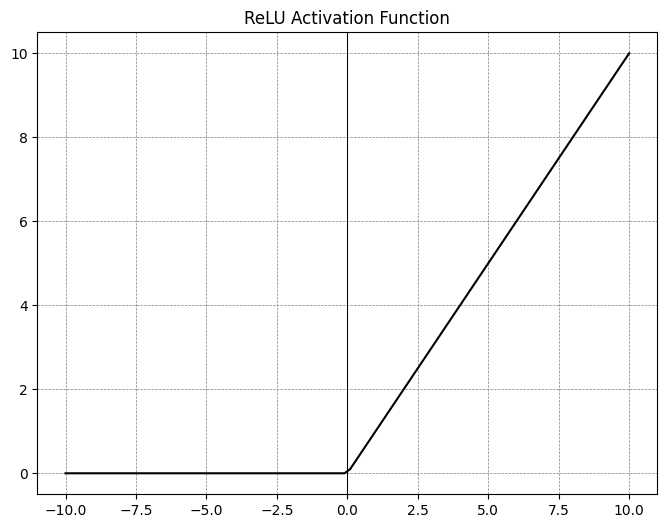

In [65]:
# Define the ReLU function
def relu(x):
    return np.maximum(0, x)

# Generate data points
x = np.linspace(-10, 10, 100)
y = relu(x)

# Plot the ReLU function
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='ReLU', color='black')
plt.title('ReLU Activation Function')
plt.axvline(0, color='black',linewidth=0.75)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()

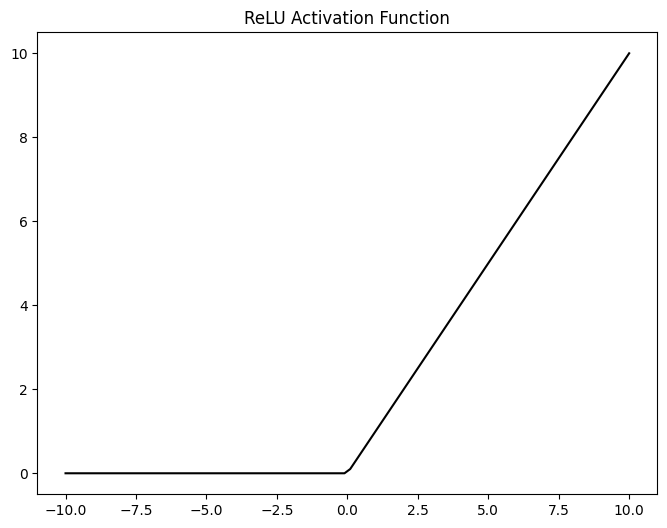

In [56]:
# Define the ReLU function
def relu(x):
    return np.maximum(0, x)

# Generate data points
x = np.linspace(-10, 10, 100)
y = relu(x)

# Plot the ReLU function
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='ReLU', color='black')
plt.title('ReLU Activation Function')
plt.show()

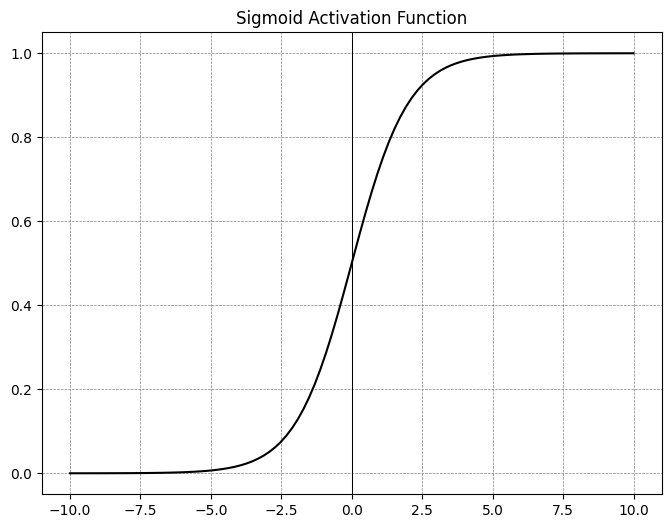

In [66]:
# Define the Sigmoid function
def sigmoid(x):
    return 1/(1+np.exp(-x))

x = np.linspace(-10, 10, 100)
y = sigmoid(x)

# Plot the ReLU function
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='Sigmoid', color='black')
plt.title('Sigmoid Activation Function')
plt.axvline(0, color='black',linewidth=0.75)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()

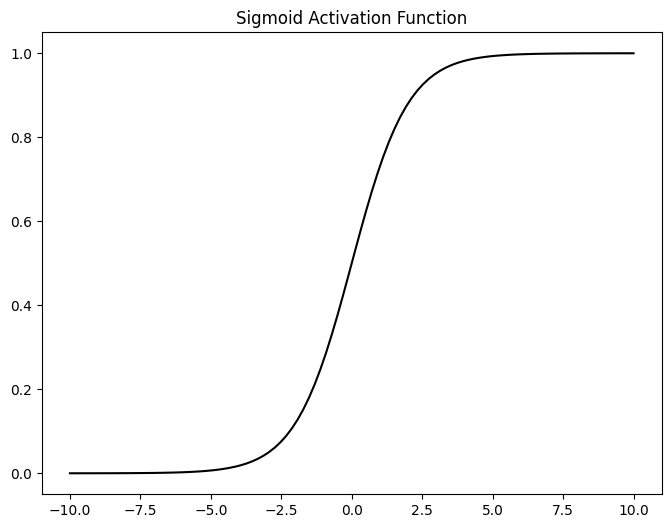

In [61]:
# Define the Sigmoid function
def sigmoid(x):
    return 1/(1+np.exp(-x))

x = np.linspace(-10, 10, 100)
y = sigmoid(x)

# Plot the ReLU function
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='Sigmoid', color='black')
plt.title('Sigmoid Activation Function')
plt.show()